In [39]:
#import the packet
using Plots
using ProgressBars
using Flux
using Flux: onehot
using Flux: Data.DataLoader
using Flux: onehotbatch, onecold, crossentropy
using Flux: @epochs
using Statistics
using MLDatasets
using CSV
using DataFrames
using Random:shuffle
using EvalMetrics

In [40]:
#import the dataset
#do 2-class classification:
#decide the wine is red or white
df_red = CSV.read("winequality-red.csv",DataFrame)
df_white = CSV.read("winequality-white.csv",DataFrame)

,fixedacidity,volatileacidity,citricacid,residualsugar,chlorides,freesulfurdioxide
,Float64,Float64,Float64,Float64,Float64,Float64
1,7.0,0.27,0.36,20.7,0.045,45.0
2,6.3,0.3,0.34,1.6,0.049,14.0
3,8.1,0.28,0.4,6.9,0.05,30.0
4,7.2,0.23,0.32,8.5,0.058,47.0
5,7.2,0.23,0.32,8.5,0.058,47.0
6,8.1,0.28,0.4,6.9,0.05,30.0
7,6.2,0.32,0.16,7.0,0.045,30.0
8,7.0,0.27,0.36,20.7,0.045,45.0
9,6.3,0.3,0.34,1.6,0.049,14.0


In [41]:
#build the model using sigmoid as Activation Function
#The input dim is 12 as 12 features and the output dim is 2 represent A and B
function sigmoidmodel(input_dim)
    model = Chain(
        Dense(input_dim,16,sigmoid),
        Dense(16,64,sigmoid),
        Dense(64,32,sigmoid),
        Dense(32,2),
        softmax
    )
    return model
end

sigmoidmodel (generic function with 1 method)

In [42]:
#Read In the data from the dataframe
csv_mat = [[r.fixedacidity,r.volatileacidity,r.citricacid,r.residualsugar,r.chlorides,r.freesulfurdioxide
        ,r.totalsulfurdioxide,r.density,r.pH,r.sulphates,r.alcohol,r.quality] for r in eachrow(df_red)]
x_redwines = rand(size(csv_mat)[1],12)
for i in 1:size(csv_mat)[1]
    x_redwines[i,1]=csv_mat[i][1]
    x_redwines[i,2]=csv_mat[i][2]
end

csv_mat = [[r.fixedacidity,r.volatileacidity,r.citricacid,r.residualsugar,r.chlorides,r.freesulfurdioxide
        ,r.totalsulfurdioxide,r.density,r.pH,r.sulphates,r.alcohol,r.quality] for r in eachrow(df_white)]
x_whitewines = rand(size(csv_mat)[1],12)
for i in 1:size(csv_mat)[1]
    x_whitewines[i,1]=csv_mat[i][1]
    x_whitewines[i,2]=csv_mat[i][2]
end

In [57]:
#get the matrix
xs = [x_redwines;x_whitewines]
xs = transpose(xs)
ys = [fill(0,size(x_redwines)[1]);fill(1,size(x_whitewines)[1])]
#trun label into 0:1 onthot-bat
ys = Flux.onehotbatch(ys,0:1)
ys = Int.(ys)

2×3198 Matrix{Int64}:
 1  1  1  1  1  1  1  1  1  1  1  1  1  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     1  1  1  1  1  1  1  1  1  1  1  1

In [54]:
#shuffle the data randomly
datalength = size(xs)[2]
index = shuffle(collect(1:datalength))

xs = xs[:,index]
ys = ys[:,index]

#split the train data and test data
train_data = Flux.DataLoader((xs[:,1:1000],ys[:,1:1000]),batchsize=20,shuffle=true)
test_data = Flux.DataLoader((xs[:,1000:end],ys[:,1000:end]),batchsize=20,shuffle=true)

DataLoader{Tuple{Matrix{Float64}, Matrix{Int64}}, Random._GLOBAL_RNG}(([6.8 6.5 … 5.9 7.4; 0.35 0.3 … 0.24 0.41; … ; 0.3895549509301137 0.09784871293391162 … 0.036789322339063735 0.9819125293793103; 0.2002115569832812 0.9710991700459517 … 0.21191872167402925 0.9886968333151588], [0 0 … 0 1; 1 1 … 1 0]), 20, 2199, true, 2199, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199], true, Random._GLOBAL_RNG())

In [58]:
#build the model
smodel = sigmoidmodel(12)

Chain(
  Dense(12, 16, σ),                     # 208 parameters
  Dense(16, 64, σ),                     # 1_088 parameters
  Dense(64, 32, σ),                     # 2_080 parameters
  Dense(32, 2),                         # 66 parameters
  NNlib.softmax,
)                   # Total: 8 arrays, 3_442 parameters, 13.945 KiB.

In [9]:
#loss function and opt
L(x,y) = Flux.mse(smodel(x),y)
opt = Descent(0.1)
ps = params(smodel)

Params([Float32[0.35325572 0.37380418 … 0.44392428 0.44145235; 0.08291709 -0.39051232 … 0.021186864 0.29175088; … ; 0.2678304 0.19595094 … 0.24193701 -0.016435262; -0.15349482 -0.33401406 … -0.20424652 -0.31753367], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[-0.13922669 0.15442832 … 0.0700008 -0.20671706; 0.17812707 0.021227967 … -0.24741949 0.016553663; … ; 0.22011758 0.061833646 … 0.24239188 -0.16556777; -0.02256479 0.27074283 … -0.042599224 0.15227655], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[-0.060970902 -0.17141804 … -0.16394028 0.10650954; -0.043524295 0.2410407 … 0.15490201 -0.14948574; … ; -0.084424734 -0.1649003 … 0.05152273 0.017310381; -0.16553402 0.22662804 … -0.21535778 -0.039698422], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.3525807 0.2063702 … -0.23383088 0.082

In [10]:
#Accurate Function
function acc(x,y)
    x = transpose(x)
    y = transpose(y)
    p=[i[2] for i in argmax(x,dims=2)]
    l=[i[2] for i in argmax(y,dims=2)]
    p = reshape(p,size(p)[1])
    l = reshape(l,size(l)[1])
    correct=sum(p.==1)
    len=size(x)[1]
    acc=correct/len
    return acc
end

acc (generic function with 1 method)

In [11]:
#the accuracy list which contains the accuracy for each epoch
acc_list_train=[]
acc_list_pred=[]

for i in ProgressBar(1:100)
    #The List which contains the accuracy for each batch(20)
    t_acc_list = []
    p_acc_list = []
    for (x,y) in train_data
        pred = smodel(x)
        ac = acc(pred,y)
        append!(t_acc_list,ac)
        Flux.train!(L,ps,[(x,y)],opt)
    end
    
    for (x,y) in test_data
        pred = smodel(x)
        ac = acc(pred,y)
        append!(p_acc_list,ac)
    end
    append!(acc_list_train,mean(t_acc_list))
    append!(acc_list_pred,mean(p_acc_list))
end

0.0%┣                                              ┫ 0/100 [00:00<00:-5, -0s/it]
1.0%┣▍                                         ┫ 1/100 [00:14<Inf:Inf, InfGs/it]
4.0%┣█▉                                             ┫ 4/100 [00:14<07:29, 5s/it]
9.0%┣████▎                                          ┫ 9/100 [00:14<02:40, 2s/it]
12.0%┣█████▍                                       ┫ 12/100 [00:14<01:53, 1s/it]
18.0%┣████████                                     ┫ 18/100 [00:14<01:08, 1it/s]
21.0%┣█████████▌                                   ┫ 21/100 [00:14<00:56, 1it/s]
27.0%┣████████████▏                                ┫ 27/100 [00:14<00:40, 2it/s]
31.0%┣██████████████                               ┫ 31/100 [00:14<00:33, 2it/s]
36.0%┣████████████████▏                            ┫ 36/100 [00:14<00:26, 2it/s]
42.0%┣███████████████████                          ┫ 42/100 [00:14<00:20, 3it/s]
46.0%┣████████████████████▊                        ┫ 46/100 [00:15<00:17, 3it/s]
52.0%┣██████████████████████

In [12]:
#show accuracy
print(sum(acc_list_pred)/(size(acc_list_pred)[1]))

0.6593956937799044

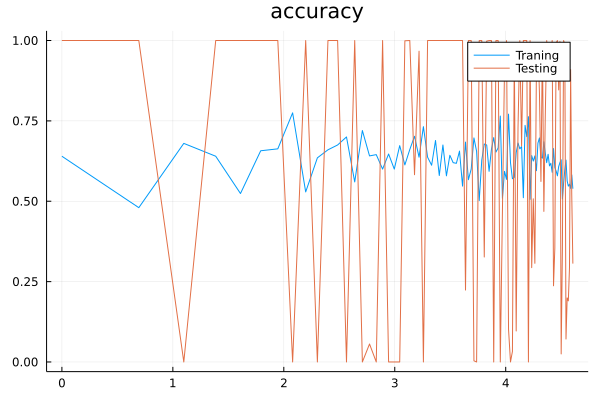

In [59]:
#draw graph
x = 1:100
x = [log(i) for i in x]
y = hcat(acc_list_train,acc_list_pred)
plot(x,y,title="accuracy",label=["Traning" "Testing"])

In [30]:
#confusion matrix
#set the matrix
confusion = zeros(2,2)
for (x,y) in test_data
    pred = smodel(x)
    pred = transpose(pred)
    label= transpose(y)
    
    p = [i[2] for i in argmax(pred,dims=2)]
    l = [i[2] for i in argmax(label,dims=2)]
    
    for (i,j) in zip(l,p)
        confusion[i,j]+=1
    end
end

In [31]:
#output the confusion matrix
print(confusion)

[584.0 501.0; 89.0 1025.0]